# Module 7 Unsupervised Machine Learning Techniques on Healthcare Data

Yiheng Shen ys3323

This article is to perform two unsupervised learning techniques: unsupervised Autoencoder and iForest with my improved 22 features, and analyze the result of anomalous providers.

### Undersampling

Due to the large volume of data, I used undersampling on the data

In [3]:
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

#load cleaned data
df = pd.read_csv('healthcare_cleaned.csv')

In [4]:
y = df['Provider_Id'].copy()
rus = RandomUnderSampler(random_state=0)
data_resampled, y_resampled = rus.fit_sample(df, y)

In [5]:
len(data_resampled)

3337

### Benchmark

These features will be my benchmark for anomaly detection: 'Average_Covered_Charges', 'Average_Covered_Charge_vs_Income_Ratio', 
 'Average_Total_Payments', 'Average_Total_Payments_by_Income_Ratio', 
                'Average_Medicare_Payments', 'Average_Medicare_Payments_by_Income_Ratio'	

In [6]:
benchmark = data_resampled[['Average_Covered_Charges', 'Average_Covered_Charge_vs_Income_Ratio', 
                'Average_Total_Payments', 'Average_Total_Payments_by_Income_Ratio', 
                'Average_Medicare_Payments', 'Average_Medicare_Payments_by_Income_Ratioe']]

### Encoding and Standardizing

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import  StandardScaler

In [8]:
#one hot encoder on df
ohe = OneHotEncoder(sparse = False)
category = ohe.fit_transform(data_resampled[['Provider_State']])
category = pd.DataFrame(category,index = data_resampled.index, columns = ohe.get_feature_names(),dtype = np.int8)

In [9]:
#standardize
numeric = data_resampled[data_resampled.columns[9:34]]
std = StandardScaler().fit_transform(numeric)
numeric = pd.DataFrame(std)
numeric.columns = data_resampled.columns[9:34].values 
data = pd.concat([category,numeric],axis=1)

### Split Data

In [10]:
from sklearn.model_selection import train_test_split
X = data
X_train,X_test= train_test_split(X, random_state = 1)

In [11]:
benchmark_test = X_test[['Average_Covered_Charges', 'Average_Covered_Charge_vs_Income_Ratio', 
                'Average_Total_Payments', 'Average_Total_Payments_by_Income_Ratio', 
                'Average_Medicare_Payments', 'Average_Medicare_Payments_by_Income_Ratioe']]

## 1. Autoencoder
An autoencoder is a special type of neural network that copies the input values to the output values and here we are interested in the hidden core layer because the hidden layers learn the most patterns of the data and ignore the “noises”.

### （1） clf1：hidden_neurons = [25, 2, 2, 25]
The input layer and the output layer has 25 neurons each. There are two hidden layers, each has two neurons.

In [9]:
from pyod.models.auto_encoder import AutoEncoder
clf1 = AutoEncoder(hidden_neurons =[25, 2, 2, 25])
clf1.fit(X_train)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 76)                5852      
_________________________________________________________________
dropout_1 (Dropout)          (None, 76)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 76)                5852      
_________________________________________________________________
dropout_2 (Dropout)          (None, 76)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1925      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
________________________________________________

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[25, 2, 2, 25],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f9e3a8dcd08>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [10]:
y_train_scores = clf1.decision_scores_ 
# get the prediction on the test data
y_test_pred = clf1.predict(X_test)  # outlier labels (0 or 1)
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf1.decision_function(X_test)  # outlier scores

y_test_pred = pd.Series(y_test_pred)
y_test_scores = pd.Series(y_test_scores)

In [58]:
y_test_pred.value_counts()

0    730
1    105
dtype: int64

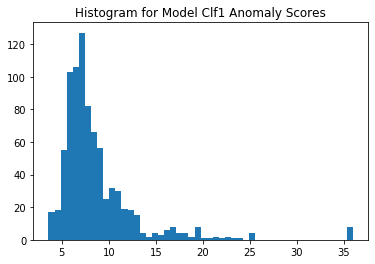

In [13]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

In [66]:
# 15 should be a good threshold
df_test = benchmark_test.reset_index(drop = True)
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<15, 0, 1)
df_test['cluster'].value_counts()

0    778
1     57
Name: cluster, dtype: int64

In [19]:
df_test.groupby('cluster').mean()

,Average_Covered_Charges,Average_Covered_Charge_vs_Income_Ratio,Average_Total_Payments,Average_Total_Payments_by_Income_Ratio,Average_Medicare_Payments,Average_Medicare_Payments_by_Income_Ratioe,score
cluster,,,,,,,
0,28886.648699,0.518749,9137.473528,0.164348,7946.319447,0.142891,35.476527
1,39195.506773,0.687104,9949.754727,0.175506,8697.078182,0.153326,8.233041


### （2）clf2：hidden_neurons = [25, 10, 2, 10, 25]
The input layer and the output layer has 25 neurons each. There are 3 hidden layers with 10, 2, and 10 neurons respectively.

In [67]:
clf2 = AutoEncoder(hidden_neurons =[25, 10, 2, 10, 25])
clf2.fit(X_train)

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf2.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 76)                5852      
_________________________________________________________________
dropout_7 (Dropout)          (None, 76)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 76)                5852      
_________________________________________________________________
dropout_8 (Dropout)          (None, 76)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 25)                1925      
_________________________________________________________________
dropout_9 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

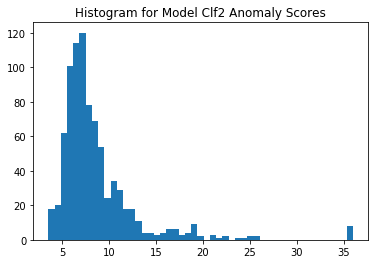

In [68]:
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf2 Anomaly Scores")
plt.show()

In [74]:
# 15 should be a good threshold
df_test = benchmark_test.reset_index(drop = True)
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<15, 0, 1)
df_test['cluster'].value_counts()

0    778
1     57
Name: cluster, dtype: int64

In [75]:
df_test.groupby('cluster').mean()

,Average_Covered_Charges,Average_Covered_Charge_vs_Income_Ratio,Average_Total_Payments,Average_Total_Payments_by_Income_Ratio,Average_Medicare_Payments,Average_Medicare_Payments_by_Income_Ratioe,score
cluster,,,,,,,
0,-0.093557,-0.096107,-0.106081,-0.106711,-0.106797,-0.10708,7.704772
1,1.260315,1.174960,1.999096,1.880544,1.983845,1.88179,21.275055


### clf3：hidden_neurons = [25, 15, 10, 2, 10,15, 25]
The input layer and the output layer has 25 neurons each. There are five hidden layers with 15, 10, 2, 10, 15 neurons respectively.

In [76]:
clf3 = AutoEncoder(hidden_neurons =[25, 15, 10, 2, 10,15, 25])
clf3.fit(X_train)

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf3.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 76)                5852      
_________________________________________________________________
dropout_14 (Dropout)         (None, 76)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 76)                5852      
_________________________________________________________________
dropout_15 (Dropout)         (None, 76)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 25)                1925      
_________________________________________________________________
dropout_16 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 15)               

Epoch 51/100
2251/2251 [==============================] - 1s 439us/step - loss: 2.2230 - val_loss: 2.4634
Epoch 52/100
2251/2251 [==============================] - 1s 449us/step - loss: 2.1939 - val_loss: 2.4350
Epoch 53/100
2251/2251 [==============================] - 1s 354us/step - loss: 2.1523 - val_loss: 2.4070
Epoch 54/100
2251/2251 [==============================] - 1s 411us/step - loss: 2.1142 - val_loss: 2.3801
Epoch 55/100
2251/2251 [==============================] - 1s 572us/step - loss: 2.0907 - val_loss: 2.3558
Epoch 56/100
2251/2251 [==============================] - 2s 686us/step - loss: 2.0692 - val_loss: 2.3314
Epoch 57/100
2251/2251 [==============================] - 1s 423us/step - loss: 2.0523 - val_loss: 2.3074
Epoch 58/100
2251/2251 [==============================] - 2s 670us/step - loss: 2.0227 - val_loss: 2.2841
Epoch 59/100
2251/2251 [==============================] - 1s 568us/step - loss: 1.9915 - val_loss: 2.2605
Epoch 60/100
2251/2251 [======================

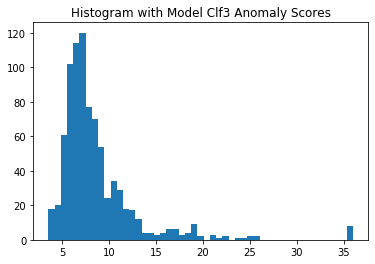

In [77]:
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram with Model Clf3 Anomaly Scores")
plt.show()

In [78]:
# 6 should be a good threshold
df_test = benchmark_test.reset_index(drop = True)
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<6, 1, 0)
df_test['cluster'].value_counts()

0    665
1    170
Name: cluster, dtype: int64

In [79]:
df_test.groupby('cluster').mean()

,Average_Covered_Charges,Average_Covered_Charge_vs_Income_Ratio,Average_Total_Payments,Average_Total_Payments_by_Income_Ratio,Average_Medicare_Payments,Average_Medicare_Payments_by_Income_Ratioe,score
cluster,,,,,,,
0,0.033402,0.025305,0.119973,0.115948,0.115780,0.112851,9.492002
1,-0.136246,-0.144861,-0.284499,-0.311387,-0.276489,-0.300543,5.263439


### Achieve Model Stability by Aggregating Multiple Models

In [80]:
from pyod.models.combination import aom, moa, average, maximization

# Put all the predictions in a data frame
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

test_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_test),
                             'clf2': clf2.decision_function(X_test),
                             'clf3': clf3.decision_function(X_test) 
                            })

/Users/yihengshen/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [81]:
train_scores.head()

,clf1,clf2,clf3
0,6.084155,6.034186,6.032230
1,7.240576,7.230576,7.230744
2,9.945015,9.930511,9.929993
3,7.459321,7.416960,7.416182
4,10.443034,10.486752,10.485136


In [82]:
train_scores_norm = StandardScaler().fit_transform(train_scores)
train_scores = pd.DataFrame(train_scores)
test_scores_norm = StandardScaler().fit_transform(test_scores)
test_scores = pd.DataFrame(test_scores)

In [83]:
train_scores_norm.shape

(2502, 3)

### (1) Average Method

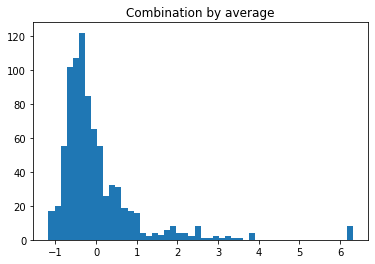

In [84]:
# Combination by average
y_by_average = average(test_scores_norm)
plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [92]:
df_test = benchmark_test.reset_index(drop = True)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score'] < 2, 0, 1)
df_test['y_by_average_cluster'].value_counts()

0    780
1     55
Name: y_by_average_cluster, dtype: int64

### (2) Maximum of Maximum Method

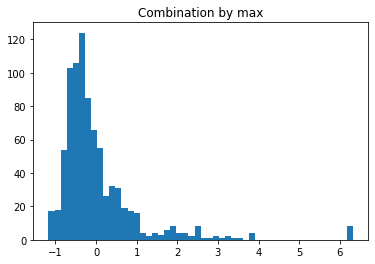

In [86]:
# Combination by max
y_by_maximization = maximization(test_scores_norm)
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

In [91]:
#from the plot I think 2 will be a good threshold
df_test = benchmark_test.reset_index(drop = True)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score'] < 2, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

0    766
1     69
Name: y_by_maximization_cluster, dtype: int64

#### outliers

In [95]:
df_test.groupby('y_by_average_cluster').mean()

,Average_Covered_Charges,Average_Covered_Charge_vs_Income_Ratio,Average_Total_Payments,Average_Total_Payments_by_Income_Ratio,Average_Medicare_Payments,Average_Medicare_Payments_by_Income_Ratioe,score,cluster,y_by_average_score
y_by_average_cluster,,,,,,,,,
0,-0.065149,-0.070134,-0.060343,-0.066148,-0.060872,-0.066320,8.587124,0.744040,-0.166138
1,1.341427,1.265735,2.092399,2.023413,2.065939,2.021344,8.760244,0.578947,3.484525


In [90]:
df_test.groupby('y_by_maximization_cluster').mean()

,Average_Covered_Charges,Average_Covered_Charge_vs_Income_Ratio,Average_Total_Payments,Average_Total_Payments_by_Income_Ratio,Average_Medicare_Payments,Average_Medicare_Payments_by_Income_Ratioe,score,cluster,y_by_maximization_score
y_by_maximization_cluster,,,,,,,,,
0,-0.065149,-0.070134,-0.060343,-0.066148,-0.060872,-0.066320,8.587124,0.744040,-0.163056
1,1.341427,1.265735,2.092399,2.023413,2.065939,2.021344,8.760244,0.578947,3.489383


### CheckPoint 1
The result of Average Method is slightly better than that of Maximization Method. So I list the result generated by the Average Method.

In [93]:
y_train_by_average = average(train_scores_norm)
X_train['y_by_average_score'] = y_train_by_average
X_train['y_by_average_cluster'] = np.where(X_train['y_by_average_score'] < 2, 0, 1)
X_test['y_by_average_score'] = y_by_average
X_test['y_by_average_cluster'] = np.where(X_test['y_by_average_score'] < 2, 0, 1)

/Users/yihengshen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yihengshen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yihengshen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [94]:
X = pd.concat([X_train, X_test])
X.y_by_average_cluster.value_counts()

0    3157
1     180
Name: y_by_average_cluster, dtype: int64

In [87]:
data_resampled['y_by_average_cluster'] = X['y_by_average_cluster']
df_anomaly = data_resampled[data_resampled['y_by_average_cluster'] == 1]

In [90]:
pd.set_option('display.max_rows', 200)
df_anomaly.Provider_Name

80                               BROOKWOOD MEDICAL CENTER
119           SCOTTSDALE HEALTHCARE-OSBORN MEDICAL CENTER
178                        BAXTER REGIONAL MEDICAL CENTER
187                        SPARKS REGIONAL MEDICAL CENTER
191                     JEFFERSON REGIONAL MEDICAL CENTER
199                         MEDICAL CENTER SOUTH ARKANSAS
207                        PHYSICIANS' SPECIALTY HOSPITAL
208                                      ST ROSE HOSPITAL
216                                MERCY GENERAL HOSPITAL
218                          RIVERSIDE COMMUNITY HOSPITAL
225                     SANTA CLARA VALLEY MEDICAL CENTER
233                        SAN GORGONIO MEMORIAL HOSPITAL
248                                SCRIPPS MERCY HOSPITAL
270                    NORTHRIDGE HOSPITAL MEDICAL CENTER
275                   REGIONAL MEDICAL CENTER OF SAN JOSE
289          COMMUNITY HOSPITAL OF THE MONTEREY PENINSULA
292                       SAINT FRANCIS MEMORIAL HOSPITAL
293           

## 2. Isolated Forest

Isolation Forest is an anomaly detection algorithm that identifies observations that do not conform to the norm

In [2]:
from pyod.models.iforest import IForest

### (1) max_samples=100

In [12]:
if1 = IForest(behaviour="new", max_samples=100) 
if1.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=100, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [13]:
y_test_scores = if1.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

0   -0.057652
1   -0.078409
2   -0.040947
3   -0.005258
4   -0.068833
dtype: float64

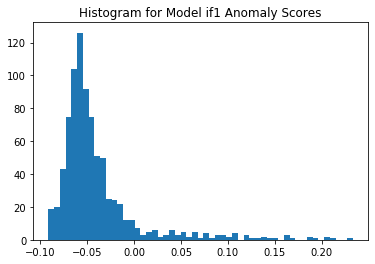

In [17]:
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model if1 Anomaly Scores")
plt.show()

In [20]:
X_test_cluster = benchmark_test.reset_index(drop = True)
X_test_cluster['distance'] = y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']<0.15, 0, 1)
X_test_cluster['cluster'].value_counts()

X_test_cluster.groupby('cluster').mean()

,Average_Covered_Charges,Average_Covered_Charge_vs_Income_Ratio,Average_Total_Payments,Average_Total_Payments_by_Income_Ratio,Average_Medicare_Payments,Average_Medicare_Payments_by_Income_Ratioe,distance
cluster,,,,,,,
0,-0.072751,-0.078276,-0.034845,-0.042637,-0.034486,-0.041228,-0.042254
1,5.363354,5.154629,5.466343,5.391143,5.309748,5.265974,0.189032


### (2) max_samples=80

In [21]:
if2 = IForest(behaviour="new", max_samples=80) 
if2.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=80, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [22]:
y_test_scores = if2.decision_function(X_test)
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

0   -0.025695
1   -0.092948
2   -0.048663
3   -0.024689
4   -0.061065
dtype: float64

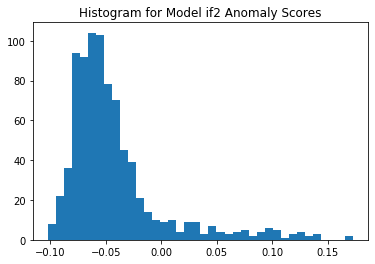

In [23]:
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model if2 Anomaly Scores")
plt.show()

In [24]:
X_test_cluster = benchmark_test.reset_index(drop = True)
X_test_cluster['distance'] = y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']<0.15, 0, 1)
X_test_cluster['cluster'].value_counts()

X_test_cluster.groupby('cluster').mean()

,Average_Covered_Charges,Average_Covered_Charge_vs_Income_Ratio,Average_Total_Payments,Average_Total_Payments_by_Income_Ratio,Average_Medicare_Payments,Average_Medicare_Payments_by_Income_Ratioe,distance
cluster,,,,,,,
0,-0.017000,-0.023034,0.025189,0.018287,0.022559,0.017191,-0.042815
1,6.605515,5.694171,5.217535,4.468471,5.599461,4.816832,0.171637


### (3) max_samples=60

In [25]:
if3 = IForest(behaviour="new", max_samples=60) 
if3.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=60, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [26]:
y_test_scores = if3.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

0   -0.052970
1   -0.099357
2   -0.045334
3   -0.002042
4   -0.087634
dtype: float64

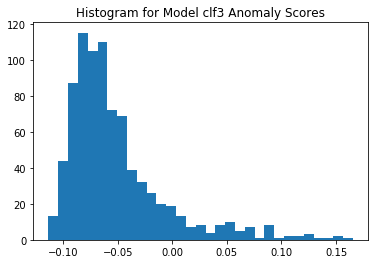

In [27]:
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model clf3 Anomaly Scores")
plt.show()

In [28]:
X_test_cluster = benchmark_test.reset_index(drop = True)
X_test_cluster['distance'] = y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']<0.15, 0, 1)
X_test_cluster['cluster'].value_counts()

X_test_cluster.groupby('cluster').mean()

,Average_Covered_Charges,Average_Covered_Charge_vs_Income_Ratio,Average_Total_Payments,Average_Total_Payments_by_Income_Ratio,Average_Medicare_Payments,Average_Medicare_Payments_by_Income_Ratioe,distance
cluster,,,,,,,
0,-0.017000,-0.023034,0.025189,0.018287,0.022559,0.017191,-0.052415
1,6.605515,5.694171,5.217535,4.468471,5.599461,4.816832,0.158433


### Achieve Model Stability by Aggregating Multiple Models

In [30]:
train_scores = pd.DataFrame({'if1': if1.decision_scores_,
                             'if2': if2.decision_scores_,
                             'if3': if3.decision_scores_
                            })

In [31]:
test_scores  = pd.DataFrame({'if1': if1.decision_function(X_test),
                             'if2': if2.decision_function(X_test),
                             'if3': if3.decision_function(X_test) 
                            })

In [32]:
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)
train_scores_norm.shape

(2502, 3)

### (1) Average Method

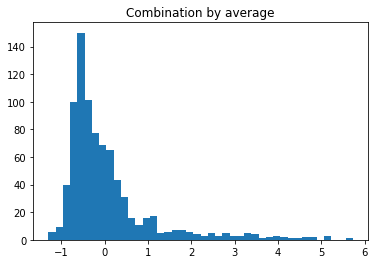

In [76]:
y_by_average = average(test_scores_norm)
             
plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

### (2) Maximum of Maximum Method

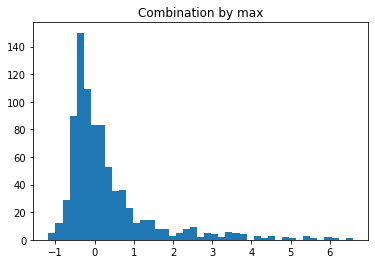

In [35]:
y_by_maximization = maximization(test_scores_norm)
             
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

### Outilers

In [59]:
df_test = benchmark_test.reset_index(drop = True)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score'] < 3, 0, 1)
df_test['y_by_average_cluster'].value_counts()

df_test.groupby('y_by_average_cluster').mean().round(2)

,Average_Covered_Charges,Average_Covered_Charge_vs_Income_Ratio,Average_Total_Payments,Average_Total_Payments_by_Income_Ratio,Average_Medicare_Payments,Average_Medicare_Payments_by_Income_Ratioe,y_by_average_score
y_by_average_cluster,,,,,,,
0,-0.12,-0.13,-0.12,-0.13,-0.12,-0.12,-0.08
1,3.18,3.14,4.05,4.07,3.98,4.00,3.96


In [60]:
df_test = benchmark_test.reset_index(drop = True)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score'] < 3, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

df_test.groupby('y_by_maximization_cluster').mean().round(2)

,Average_Covered_Charges,Average_Covered_Charge_vs_Income_Ratio,Average_Total_Payments,Average_Total_Payments_by_Income_Ratio,Average_Medicare_Payments,Average_Medicare_Payments_by_Income_Ratioe,y_by_maximization_score
y_by_maximization_cluster,,,,,,,
0,-0.14,-0.15,-0.13,-0.14,-0.13,-0.14,0.12
1,2.99,2.93,3.75,3.72,3.69,3.67,4.27


### CheckPoint 2
Average Method is better than Maximum of Maximum Method indicated by all benchmarks. This is the list of overcharging hospitals.

In [65]:
y_train_by_maximization = maximization(train_scores)
X_train['y_by_maximization_score'] = y_train_by_maximization
X_train['y_by_maximization_cluster'] = np.where(X_train['y_by_maximization_score'] < 2, 0, 1)
X_test['y_by_maximization_score'] = y_by_maximization
X_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score'] < 2, 0, 1)

/Users/yihengshen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yihengshen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yihengshen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [67]:
X = pd.concat([X_train, X_test])
X.y_by_maximization_cluster.value_counts()

0    3268
1      69
Name: y_by_maximization_cluster, dtype: int64

In [68]:
data_resampled['y_by_maximization_cluster'] = X['y_by_maximization_cluster']
df_anomaly = data_resampled[data_resampled['y_by_maximization_cluster'] == 1]

In [73]:
df_anomaly.Provider_Name

187                       SPARKS REGIONAL MEDICAL CENTER
218                         RIVERSIDE COMMUNITY HOSPITAL
248                               SCRIPPS MERCY HOSPITAL
289         COMMUNITY HOSPITAL OF THE MONTEREY PENINSULA
292                      SAINT FRANCIS MEMORIAL HOSPITAL
299                         SANTA ROSA MEMORIAL HOSPITAL
301       JOHN MUIR MEDICAL CENTER - WALNUT CREEK CAMPUS
306                                  WASHINGTON HOSPITAL
318                POMONA VALLEY HOSPITAL MEDICAL CENTER
321                  PROVIDENCE SAINT JOSEPH MEDICAL CTR
394                         HUNTINGTON MEMORIAL HOSPITAL
420                          MEMORIAL HOSPITAL LOS BANOS
438                     LA PALMA INTERCOMMUNITY HOSPITAL
445        UNIVERSITY OF CALIFORNIA DAVIS MEDICAL CENTER
453                          CEDARS-SINAI MEDICAL CENTER
473                             FRESNO SURGICAL HOSPITAL
485                  GREATER EL MONTE COMMUNITY HOSPITAL
490                            

## Summary

Autoencoder gives a list of 180 hospitals while IForest gives 69. Result from these two methods is very similar with the results of KNN.